In [22]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import LightSource
hcm = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","khaki","saddlebrown","grey","lightgrey","snow"])#
Hmax=2500
def show_H_stats(Hc,dx,shading=False,nzbins=81):
    ny,nx = np.shape(Hc)
    Hc_max = np.max(Hc)
    Hc_min = np.min(Hc)
    Hc_mean = np.mean(Hc)
    Hc_std = np.std(Hc)
    
    x = np.linspace(dx/2,nx*dx-dx/2,nx)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    im = ax[0].imshow(Hc, cmap=hcm,vmin=0,vmax=Hmax, origin='lower',extent=extent,interpolation='none',visible=not(shading))
    if shading:
        ls = LightSource(325, 45)
        rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hmax, vert_exag=Hc_max/Hmax/dx, blend_mode='soft')
        ax[0].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
    plt.colorbar(im,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
    ax[0].set_xlabel("x (km)")
    ax[0].set_ylabel("y")
    
    z_bins = np.linspace(0.,1.0001,nzbins)*Hmax
    
    values,_,_ = ax[1].hist(Hc.flatten(),bins=z_bins[:],density=False, orientation="horizontal",alpha=0.5,label="Distribution")
    xmax = (np.max(values[1:])+np.min(values[1:]))*1.1
    ax[1].set_xlim([0,xmax])
    ax[1].set_ylim([0,Hmax])
#     ax[1].set_yticks([])
    ax[1].set_xlabel("Number of pixel")
    ax[1].set_ylabel("Altitude")
    
    ax_cum = ax[1].twiny()
    ax_cum.hist(Hc.flatten(),bins=z_bins[:], density=True, histtype="step",color='orange', orientation="horizontal",
                cumulative=True, label="CDF")
    ax_cum.set_xlim([0,1])
    
    above_mean_ratio = np.mean(Hc>Hc_mean)
    ax[1].axhline(np.mean(Hc),color='r',linestyle='--',label='Mean')
    ax[1].text(xmax/8,Hc_mean+Hmax/20,"Mean "+str(round(Hc_mean))+'m',color='r',ha='center', va='center')
    
    #ax[1].annotate(text='Std', xy=(xmax/2,Hc_mean-Hc_std), xytext=(xmax/2,Hc_mean+Hc_std), arrowprops=dict(arrowstyle='<->'),color='g')
    #ax[1].annotate(text='', xy=(0.5,(Hc_mean-Hc_std)/Hmax), xytext=(0.5,(Hc_mean+Hc_std)/Hmax), arrowprops=dict(arrowstyle='<->'),color='g')

    #ax[1].plot([xmax/2,xmax/2],[Hc_mean-Hc_std,Hc_mean+Hc_std],color='g',linewidth=3)
    #ax[1].arrow(xmax/2,Hc_mean,0,Hc_std,width=0.01,color='g',length_includes_head=True)
    #ax[1].arrow(xmax/2,Hc_mean,0,-Hc_std,color='r',length_includes_head=True)
    import matplotlib.patches as patches
    double_arrow = patches.FancyArrowPatch((xmax/2,Hc_mean-Hc_std),(xmax/2,Hc_mean+Hc_std),color='g', arrowstyle='<->', mutation_scale=20)#, arrowstyle='<|-|>'
    ax[1].add_patch(double_arrow)
    
    ax[1].text(xmax/2,Hc_mean+Hc_std+Hmax/40,"Std "+str(round(Hc_std))+'m',color='g',ha='center', va='center')
    
    ax_cum.text(1/2,Hmax*3/4,str(round(above_mean_ratio*100))+' % > mean',color='r',ha='center', va='center')
    ax_cum.set_xlabel("CDF")
    lines, labels = ax[1].get_legend_handles_labels() ; lines2, labels2 = ax_cum.get_legend_handles_labels()
    ax[1].legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    

def show_S_stats(Hc,dx,lat=0.,Smax = 60,nzbins=81,nsbins=61,deg=False):
    ny,nx = np.shape(Hc)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    Hcmax = np.max(Hc)
    Hcs = np.zeros((ny+1,nx+1))
    Hcs[:-1,:-1] = np.copy(Hc)
    Hcs[-1,:] = Hcs[0,:]
    Hcs[:,-1] = Hcs[:,0]
    slopes = np.sqrt( ((Hcs[:-1,:-1]+Hcs[1:,:-1]-Hcs[:-1,1:]-Hcs[1:,1:])/2/dx/np.cos(np.pi*(lat)/180))**2 + ((Hcs[:-1,:-1]+Hcs[:-1,1:]-Hcs[1:,:-1]-Hcs[1:,1:])/2/dx)**2 )
    Hc_slopes = (Hcs[:-1,:-1]+Hcs[1:,:-1]+Hcs[:-1,1:]+Hcs[1:,1:])/4
    if deg:
        slope_bins = np.linspace(0.,Smax,int(Smax)+1)
        slopes = 180/np.pi*np.arctan(slopes)
    else:
        Smax = np.tan(Smax/180*np.pi)
        slope_bins = np.linspace(0.,Smax,nsbins)
    z_bins = np.linspace(0.,1.0001,nzbins)*Hmax
    
    ims = ax[0].imshow(slopes, cmap='rainbow',vmin=0,vmax=Smax,extent=extent, origin='lower',interpolation='none')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    ax[0].set_xlabel("x (km)")
    ax[0].set_ylabel("y")
    
    hist_field,_,_,imhs = ax[1].hist2d(slopes.flatten(),Hc_slopes.flatten(),
                                       bins=(slope_bins,z_bins),density=False,cmap='magma_r',
                                       norm=matplotlib.colors.LogNorm(vmin=1,vmax=slopes.size/10) )
    plt.colorbar(imhs,ax=ax[1],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    
    if not(deg):
        ax[1].plot( np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5)
    else:
        slopes = np.tan(slopes/180*np.pi)
        slope_bins = np.linspace(0.,np.max(slopes),1000)
        hist_field,_,_,imhs = ax[1].hist2d(slopes.flatten(),Hc_slopes.flatten(),bins=(slope_bins,z_bins),visible=False)
        hist_mean_slopes = np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0)
        ax[1].plot( 180/np.pi*np.arctan(hist_mean_slopes) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5,label="Mean slope")
    
    ax[1].set_ylim([0,Hcmax])
    ax[1].set_xlim([0,Smax])
    ax[1].set_xlabel("Slope")
    plt.show()

def show_G_stats(Hc,dx,lat=0.,Gmax = 1e-2 ,nzbins=81,nsbins=61):
    ny,nx = np.shape(Hc)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    Hcmax = np.max(Hc)
    Hcs = np.zeros((ny+2,nx+2))
    Hcs[1:-1,1:-1] = np.copy(Hc)
    Hcs[0,:] = Hcs[-2,:]
    Hcs[-1,:] = Hcs[1,:]
    Hcs[:,0] = Hcs[:,-2]
    Hcs[:,-1] = Hcs[:,1]
    laplas = (Hcs[1:-1,:-2]+Hcs[1:-1,2:] - 2*Hcs[1:-1,1:-1])/(dx*np.cos(np.pi*(lat)/180))**2 + (Hcs[:-2,1:-1]+Hcs[2:,1:-1] - 2*Hcs[1:-1,1:-1])/dx**2
    
    lapla_bins = np.linspace(-Gmax,Gmax,nsbins)
    z_bins = np.linspace(0.,1.0001,nzbins)*Hmax
    
    ims = ax[0].imshow(laplas, cmap='seismic',vmin=-Gmax,vmax=Gmax,extent=extent, origin='lower',interpolation='none')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='both')
    ax[0].set_xlabel("x (km)")
    ax[0].set_ylabel("y")
    
    hist_field,_,_,imhs = ax[1].hist2d(laplas.flatten(),Hc.flatten(),
                                       bins=(lapla_bins,z_bins),density=False,cmap='magma_r',
                                       norm=matplotlib.colors.LogNorm(vmin=1,vmax=laplas.size/10) )
    plt.colorbar(imhs,ax=ax[1],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    
    hist_mean_laplas = np.sum(hist_field * (lapla_bins[1:]/2+lapla_bins[:-1]/2).reshape((len(lapla_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0)
    ax[1].plot( hist_mean_laplas ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5,label="mean(laplacien)" )

    
    
    gammas = laplas**2
    gamma_bins = np.linspace(0.,np.max(gammas),1000)
    hist_field,_,_,imhs = ax[1].hist2d(gammas.flatten(),Hc.flatten(),bins=(gamma_bins,z_bins),visible=False)
    hist_mean_gammas = np.sum(hist_field * (gamma_bins[1:]/2+gamma_bins[:-1]/2).reshape((len(gamma_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0)
    
    ax[1].plot( np.sqrt(hist_mean_gammas-hist_mean_laplas**2) ,(z_bins[1:]+z_bins[:-1])/2  , color='green',lw=1.5,label="Gamma = std(laplacien)")

    ax[1].set_ylim([0,Hcmax])
    ax[1].set_xlim([-Gmax,Gmax])
    ax[1].set_xlabel("Laplacien")
    plt.show()
    
def spectrum2D(data2D,dx,dk=1):
    _,nx = np.shape(data2D)
    fourier_image = np.fft.fftn(data2D)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(nx)*nx
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(1.-0.5*dk, nx//2+1, dk)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    # Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    Abins *= 2*np.pi * kvals
    return dx*nx/kvals,dx**2*Abins/nx**2#2*np.sqrt(Abins)/nx**2#Abins#

def show_spectrum_stats(Hc,dx,dk=1):
    ny,nx = np.shape(Hc)
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    
    ims = ax[0].imshow(np.fft.fftshift(np.abs(np.fft.fft2(Hc))**2)/nx,norm=matplotlib.colors.LogNorm(vmin=1e2,vmax=1e12), origin='lower',interpolation='none',cmap='Greys')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='both')
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    
    lamda,power = spectrum2D(Hc,dx,dk)
    #Px = np.mean(np.abs(np.fft.fft(Hc,axis=1))**2,axis=0)/nx
    #Py = np.mean(np.abs(np.fft.fft(Hc,axis=0))**2,axis=1)/ny
    
    lamda_crit = 1000
    PSD_crit = 1e11
    minlamda = np.min(lamda)
    maxlamda = np.max(lamda)
    scp = 5 # small scale power
    if maxlamda<lamda_crit:
        ax[1].loglog(np.array([minlamda,lamda_crit])/1000,PSD_crit*np.array([(minlamda/lamda_crit)**scp,1.]),color='k',linestyle='--',label='theory')
    elif minlamda>lamda_crit:
        ax[1].loglog(np.array([lamda_crit,maxlamda])/1000,PSD_crit*np.array([1.,(maxlamda/lamda_crit)**2]),color='k',linestyle='--',label='theory')
    else:
        ax[1].loglog(np.array([minlamda,lamda_crit,maxlamda])/1000,PSD_crit*np.array([(minlamda/lamda_crit)**scp,1.,(maxlamda/lamda_crit)**2]),color='k',linestyle='--',label='theory')
    
    PSD_min = PSD_crit/1e6
    ax[1].loglog(lamda/1000, power,color='k',label='2D')
    #ax[1].loglog(dx*l/1000, Px[:nx//2],color='r',label='Mean x')
    #ax[1].loglog(dx*l/1000, Py[:ny//2],color='b',label='Mean y')
    ax[1].set_xlabel("Wavelength (km)")
    ax[1].set_ylabel("PSD")
    ax[1].set_ylim([PSD_min,PSD_crit*1e6])
    #ax[1].legend()
    #ax[1].set_ylabel("Amplitude spectrum (m)")
        
    plt.show()
    

def save_txt_ZSDATA(zs,name):
    ny,nx = zs.shape
    with open('ZSDATA_'+name+'.txt','w') as f:
        f.write('ZSDATA\n')
        for j in range(ny):
            for i in range(nx):
                f.write("{:.1f} ".format(zs[j,i]))
            f.write('\n')

def correct_edges(zs):
    # function that forces zs[0,:]==zs[-1,:] and zs[:,0]==zs[:,-1]
    edge0 = (zs[:,0]+zs[:,-1])/2
    zs[:,0] = edge0
    zs[:,-1] = edge0
    edge1 = (zs[0,:]+zs[-1,:])/2
    zs[0,:] = edge1
    zs[-1,:] = edge1

def filter_smallscales_cyclic(z,n,coef=1/6):
    d = np.zeros_like(z)
    for i in range(n):
        d[1:-1,1:-1] = ( z[2:,1:-1]+z[:-2,1:-1]+z[1:-1,2:]+z[1:-1,:-2]-4*z[1:-1,1:-1])
        
        d[0,1:-1] = ( z[1,1:-1]+z[-1,1:-1]+z[0,2:]+z[0,:-2]-4*z[0,1:-1])
        d[1:-1,0] = ( z[2:,0]+z[:-2,0]+z[1:-1,1]+z[1:-1,-1]-4*z[1:-1,0])
        d[-1,1:-1] = ( z[0,1:-1]+z[-2,1:-1]+z[-1,2:]+z[-1,:-2]-4*z[-1,1:-1])
        d[1:-1,-1] = ( z[2:,-1]+z[:-2,-1]+z[1:-1,0]+z[1:-1,-2]-4*z[1:-1,-1])
        
        d[0,0] = ( z[1,0]+z[-1,0]+z[0,1]+z[0,-1]-4*z[0,0])
        d[-1,0] = ( z[0,0]+z[-2,0]+z[-1,1]+z[-1,-1]-4*z[-1,0])
        d[0,-1] = ( z[1,-1]+z[-1,-1]+z[0,0]+z[0,-2]-4*z[0,-1])
        d[-1,-1] = ( z[0,-1]+z[-2,-1]+z[-1,0]+z[-1,-2]-4*z[-1,-1])
        #print(np.any(d==0))
        z += coef * d
        
def filter_smallscales_with_flat_edges(z,n,coef=1/6):
    d = np.zeros_like(z)
    for i in range(n):
        d[1:-1,1:-1] = ( z[2:,1:-1]+z[:-2,1:-1]+z[1:-1,2:]+z[1:-1,:-2]-4*z[1:-1,1:-1])
        d[0,1:-1] = ( z[1,1:-1]+z[-2,1:-1]+z[0,2:]+z[0,:-2]-4*z[0,1:-1])
        d[1:-1,0] = ( z[2:,0]+z[:-2,0]+z[1:-1,1]+z[1:-1,-2]-4*z[1:-1,0])
        d[0,0] = ( z[1,0]+z[-2,0]+z[0,1]+z[0,-2]-4*z[0,0])
        d[-1,:-1] = np.copy(d[0,:-1])
        d[:,-1] = np.copy(d[:,0])
        #print(np.any(d==0))
        z += coef * d


def gaussian_filter(periodic_2Darray,dx,lc):
    ny,nx = np.shape(periodic_2Darray)
    #k = 2*np.pi*np.fft.rfftfreq(nx,dx)
    k = 2*np.pi*np.fft.fftfreq(nx,dx)
    m = 2*np.pi*np.fft.fftfreq(ny,dx)
    kk,mm = np.meshgrid(k,m)
    k2 = kk**2+mm**2
    kc = 2*np.pi/lc
    #return np.fft.irfft2(np.exp(-k2/kc**2/2)*np.fft.rfft2(periodic_2Darray) )
    return np.real(np.fft.ifft2(np.exp(-k2/kc**2/2)*np.fft.fft2(periodic_2Darray) ))

def get_zs_dx(relief):
    zs = np.load('../ZSDATA_npy/'+relief+'.npy')
    dx = int(relief[6:9])
    if relief[:4]=='MO10': zs = np.roll(zs,len(zs)//2,0) # for MO10
    
    if relief[:4]=='MOPL':
        #zs = gaussian_filter(zs,dx,5*dx)

        zs[1:,1:] = gaussian_filter(zs[1:,1:],dx,6*dx)
        zs[0,:] = zs[-1,:] ; zs[:,0] = zs[:,-1]
        #print(zs[0,0],zs[-1,0],zs[0,-1],zs[-1,-1], np.all(zs[0,:] == zs[-1,:]) )

        #filter_smallscales_cyclic(zs,4,coef=0.1)

        #correct_edges(zs)
        #filter_smallscales_with_flat_edges(zs,40,0.01)
    return zs,dx

In [23]:
nx = 512 # 256
ny = nx
dx = 100 # 200
xmax = dx*nx
x = np.linspace(dx/2,xmax-dx/2,nx)
xx,yy = np.meshgrid(x,x)

#zs = 500*np.ones((ny,nx))
zs = np.maximum(0., 2000*(1 - np.abs(xx-xmax/2)/(xmax/4)) )
#zs = np.maximum(0., 2000*(1 - np.sqrt((xx-xmax/2)**2+(yy-xmax/2)**2)/(xmax/4)) )

#zs = gaussian_filter(zs,dx,6*dx)
filter_smallscales_cyclic(zs,5,coef=0.1) # for TRI and CON

In [3]:
np.save('F500_M100m',zs)
save_txt_ZSDATA(zs,'F500_M100m')

In [29]:
np.save('TRI2_M100m',zs)
save_txt_ZSDATA(zs,'TRI2_M100m')

In [2]:
#np.save('TRI2_S200m',zs)

In [3]:
#np.save('TRI2_M100m',zs)

In [4]:
#np.save('CON2_S200m',zs)

In [5]:
for relief in []:#'TRI2_M100m'
    save_txt_ZSDATA(zs,relief)

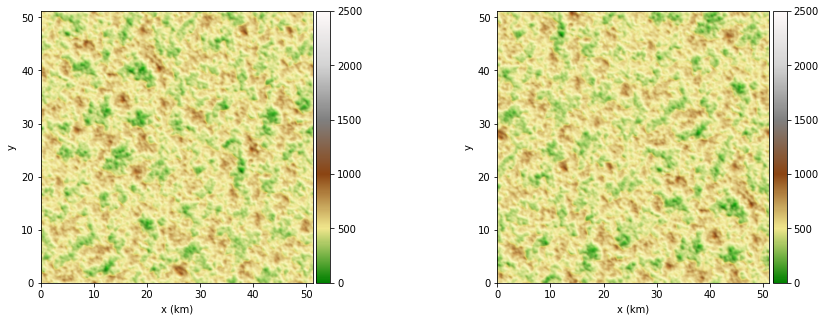

In [3]:
def check_cyclicity(relief):
    Hc,dx = get_zs_dx(relief)
    
    shading=True
    ny,nx = np.shape(Hc)
    extent = (0,nx*dx/1000,0,ny*dx/1000)
    Hcmax = Hmax#np.max(Hc)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    for i in range(2):
        im = ax[i].imshow(Hc, cmap=hcm,vmin=0,vmax=Hcmax, origin='lower',interpolation='none',visible=not(shading))
        if shading:
            ls = LightSource(325, 45)
            rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hcmax, vert_exag=Hcmax/Hmax/dx, blend_mode='soft')
            ax[i].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
        plt.colorbar(im,ax=ax[i],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
        ax[i].set_xlabel("x (km)")
        ax[i].set_ylabel("y")
        
        Hc = np.roll(Hc,ny//2,0)
        Hc = np.roll(Hc,nx//2,1)
        
check_cyclicity('MO10_M100m')

In [40]:
def identity_card_ZS(relief):
    zs,dx = get_zs_dx(relief)
    show_all(zs,dx)
    
def show_all(zs,dx):
    show_H_stats(zs,dx,shading=True)
    show_S_stats(zs,dx,deg=True)
    show_G_stats(zs,dx)
    dk = 4 if relief[:3] in ['CON','TRI'] else 1
    show_spectrum_stats(zs,dx,dk)
    save_txt_ZSDATA(zs,relief)


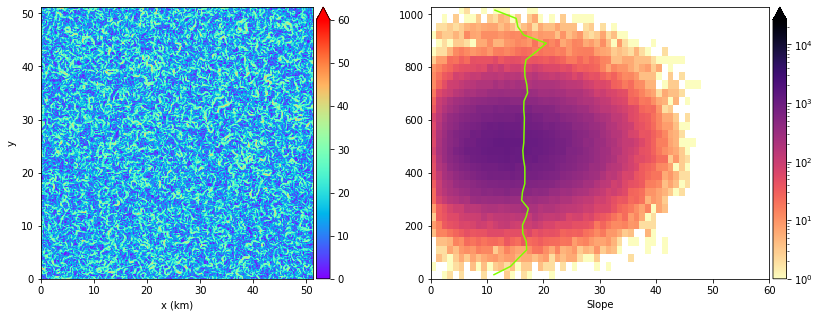

0.0 1027.6388742974202
23.843905605408516 1006.2188974643028


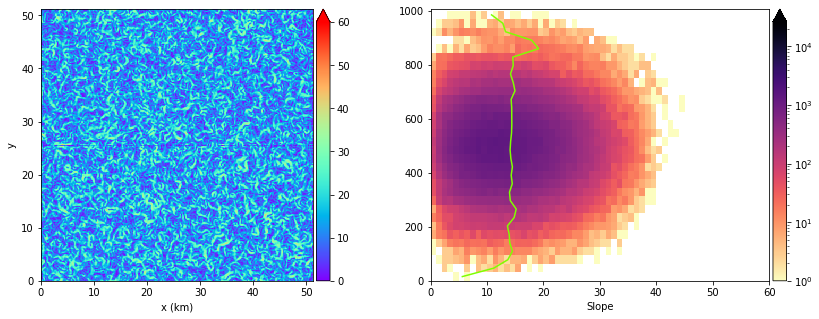

In [44]:
def S_card_ZS(relief):
    zs = np.load('../ZSDATA_npy/'+relief+'.npy')
    dx = int(relief[6:9])
    show_S_stats(zs,dx,deg=True)
    print(np.min(zs),np.max(zs))
    zs,dx = get_zs_dx(relief)
    ny,nx = np.shape(zs)
    #correct_edges(zs)
    #filter_smallscales_with_flat_edges(zs,3)
    print(np.min(zs),np.max(zs))
    #save_txt_ZSDATA(zs,relief)
    #zs = np.roll(zs,nx//2,1)
    zs = np.roll(zs,ny//2,0)
    show_S_stats(zs,dx,deg=True)
S_card_ZS('MO10_M100m')

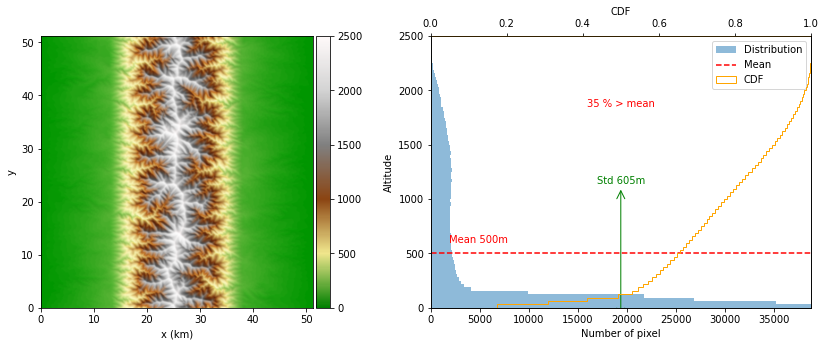

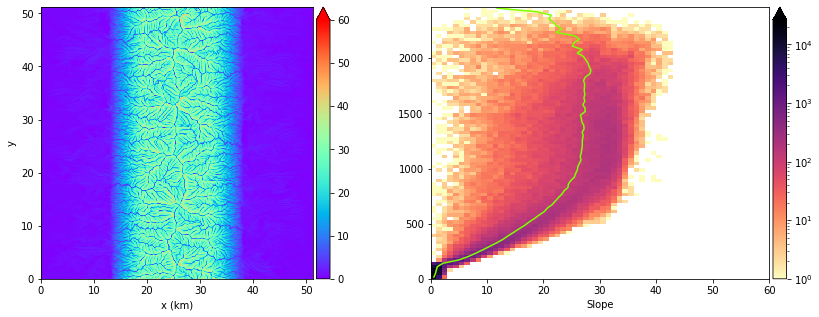

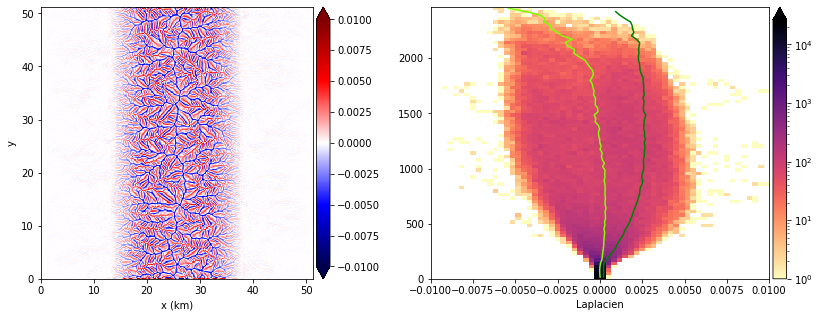

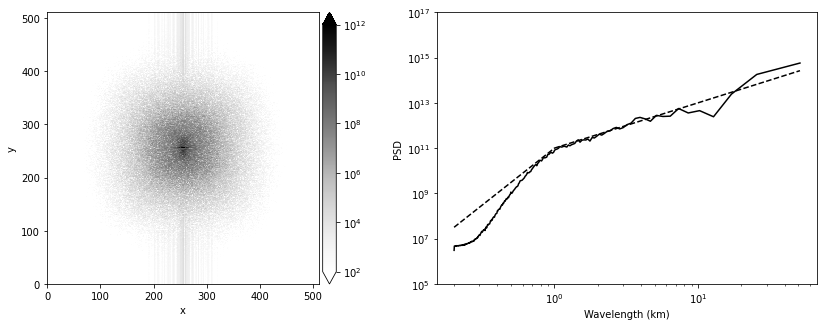

In [23]:
identity_card_ZS('MOPL_M100m')

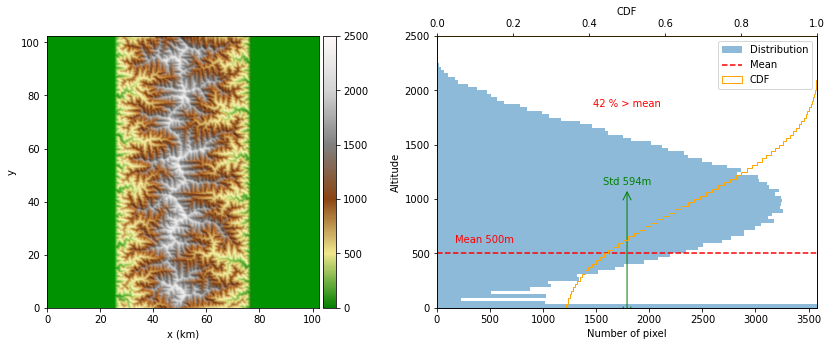

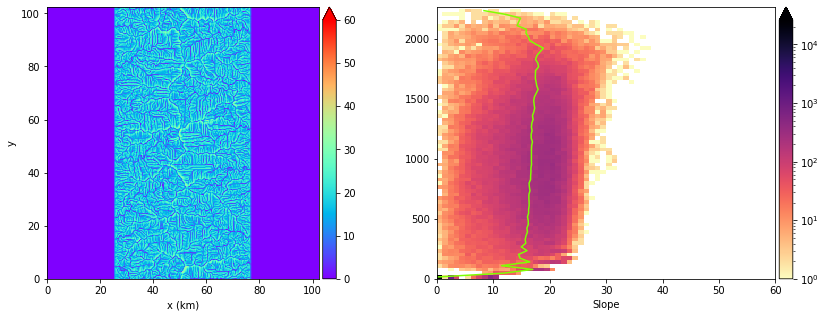

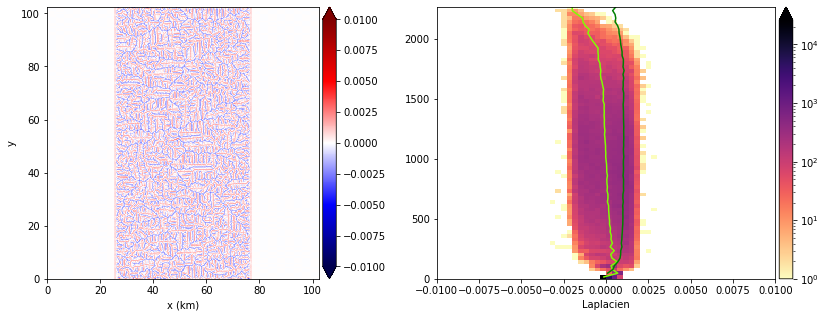

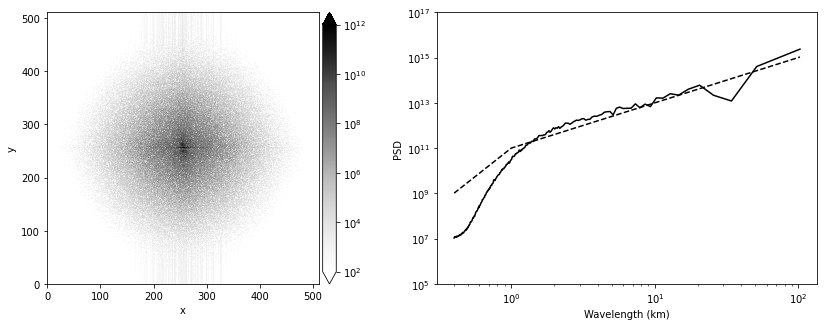

In [24]:
identity_card_ZS('MOPL_M200m')

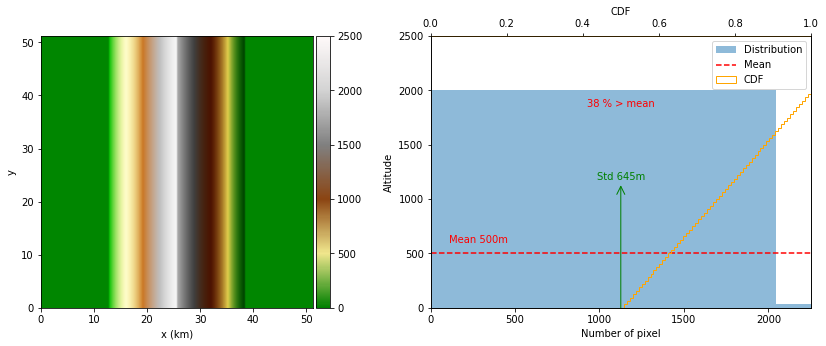

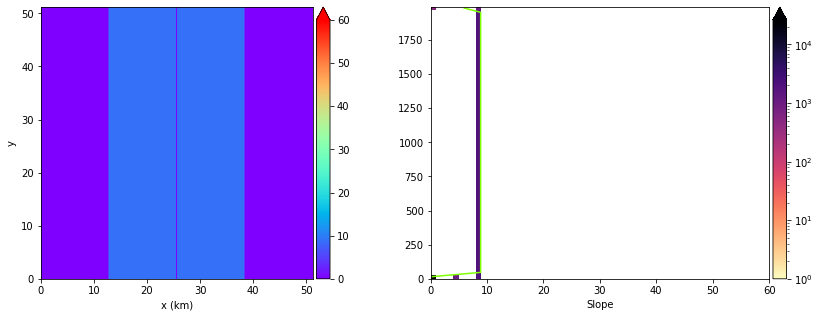

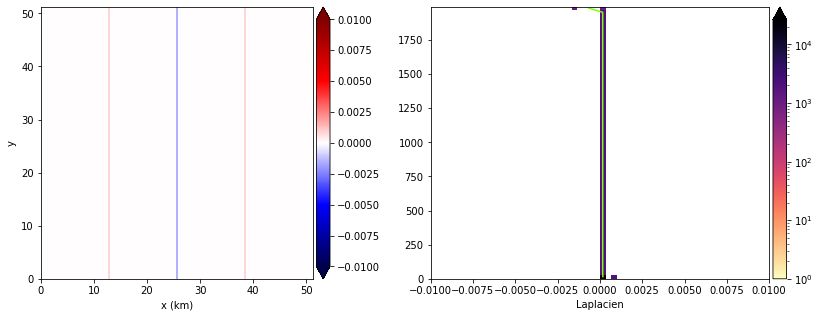

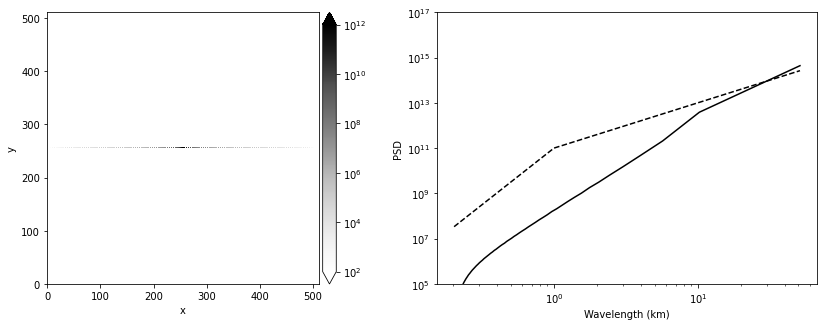

In [25]:
identity_card_ZS('TRI2_M100m')

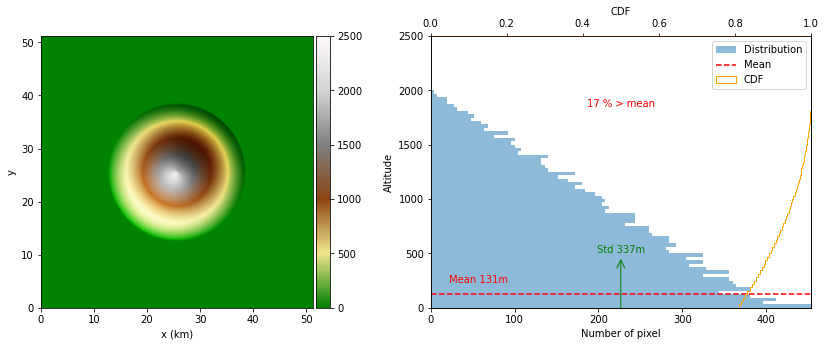

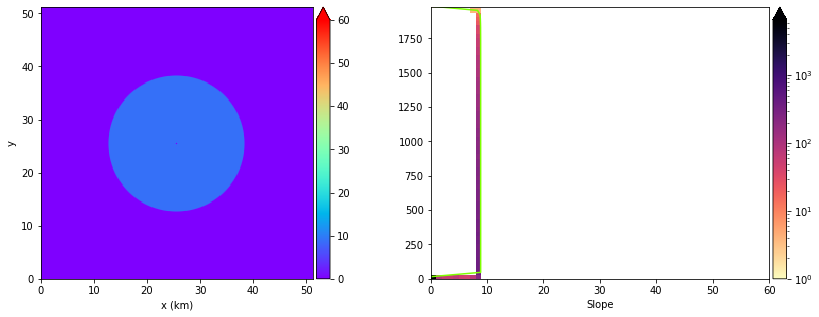

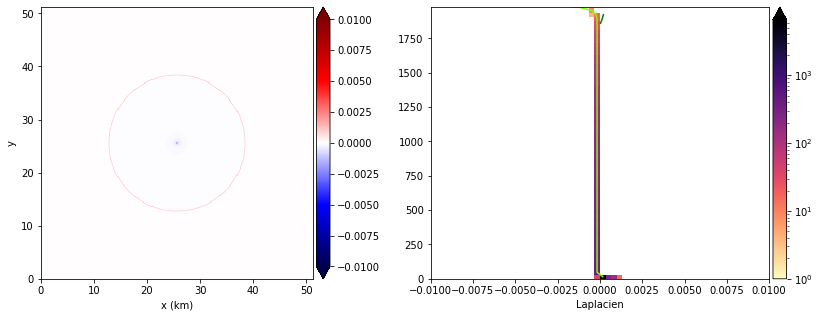

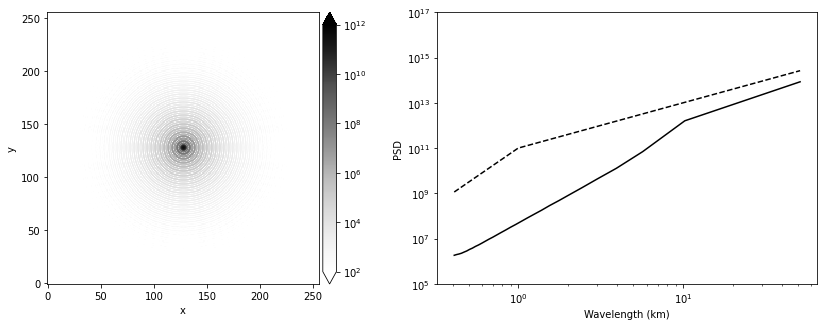

In [26]:
identity_card_ZS('CON2_S200m')

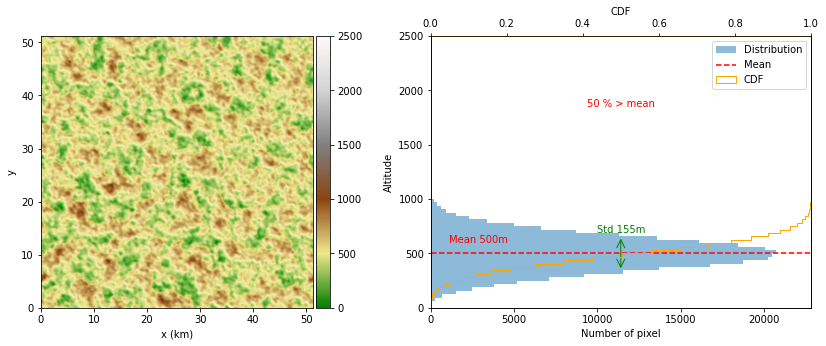

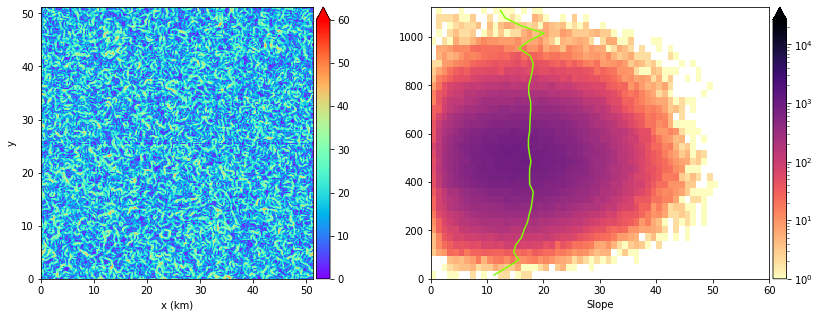

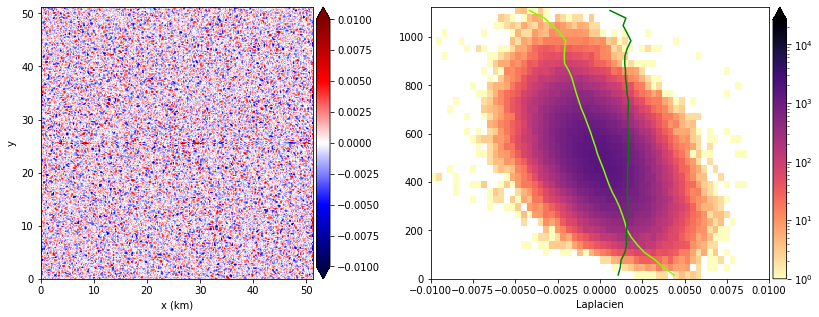

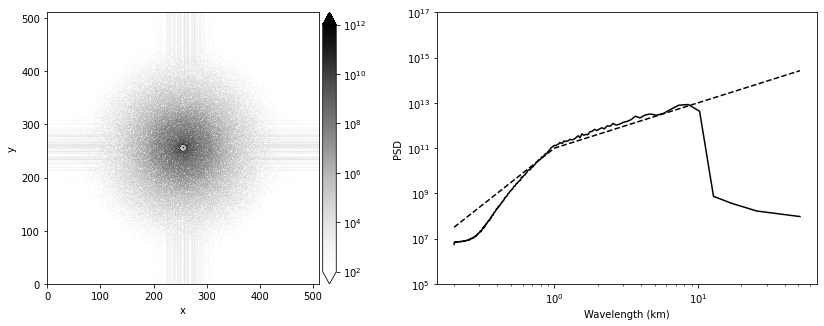

In [27]:
identity_card_ZS('MO10_M100m')

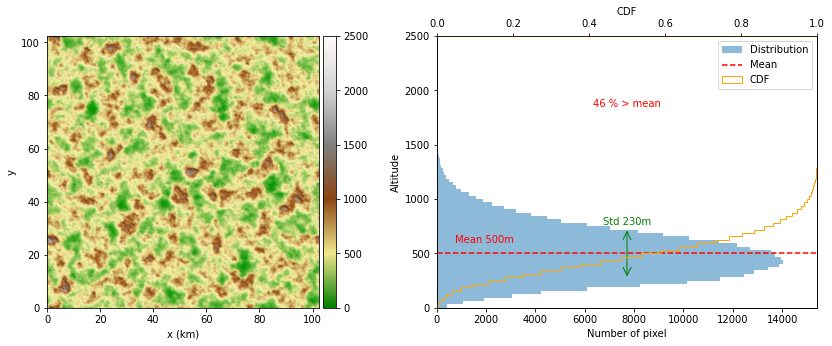

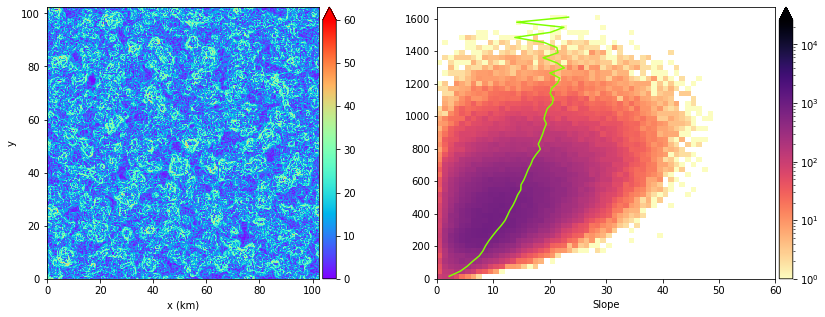

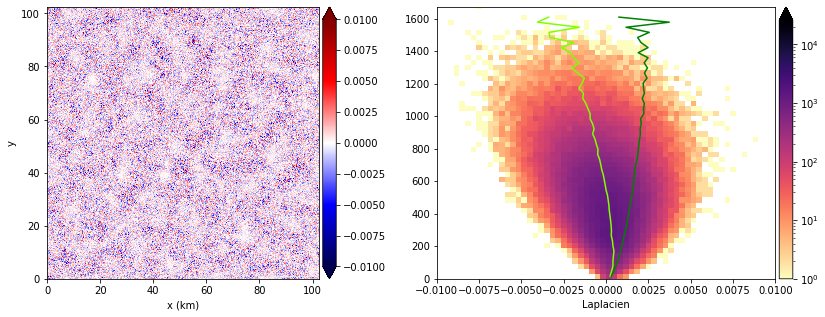

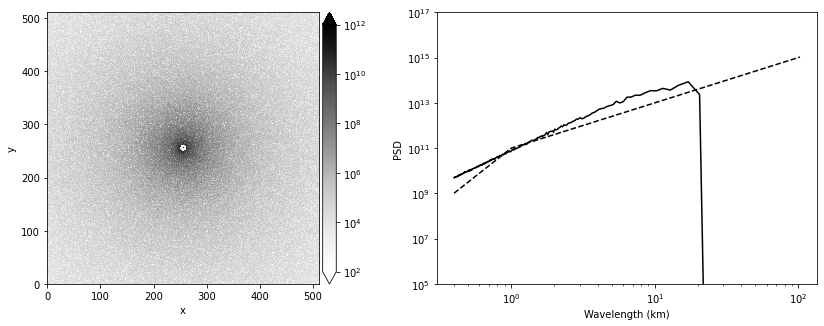

In [29]:
identity_card_ZS('MO20_M200m')

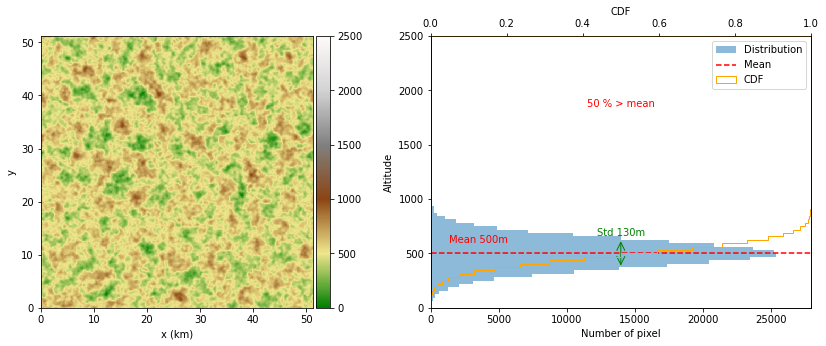

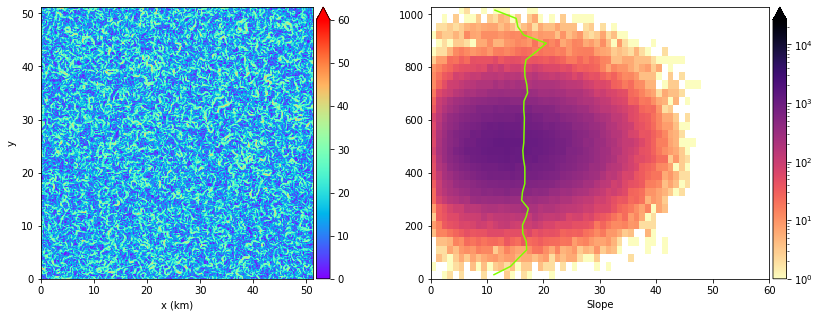

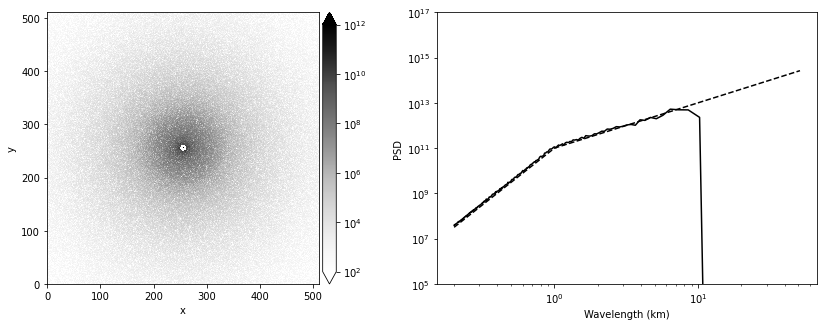

In [14]:
identity_card_ZS('MO10_M100m')

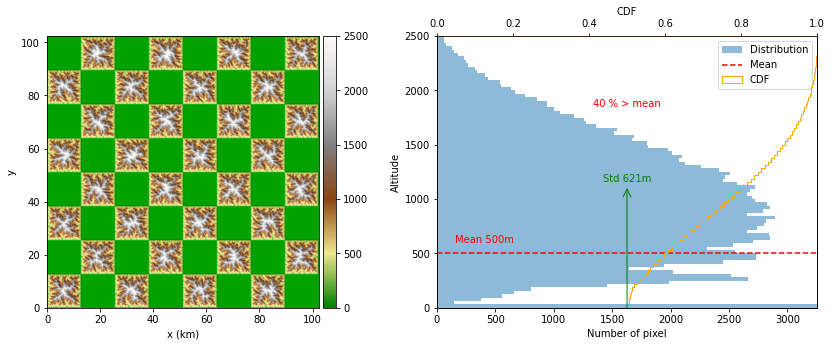

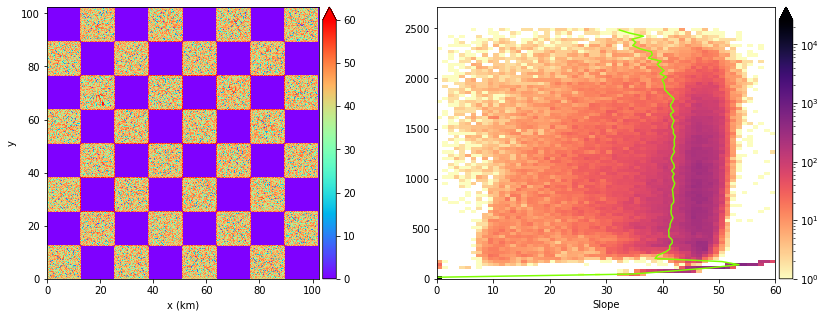

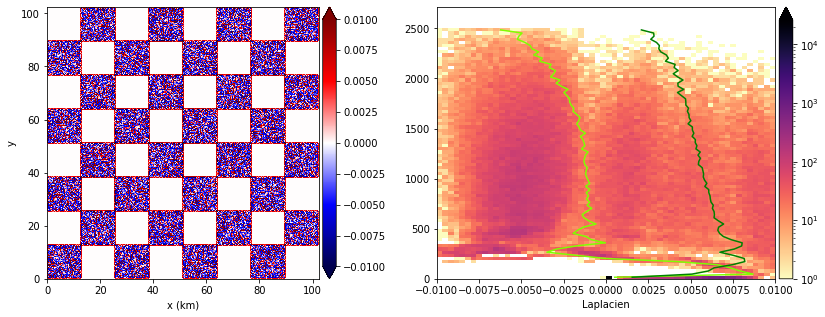

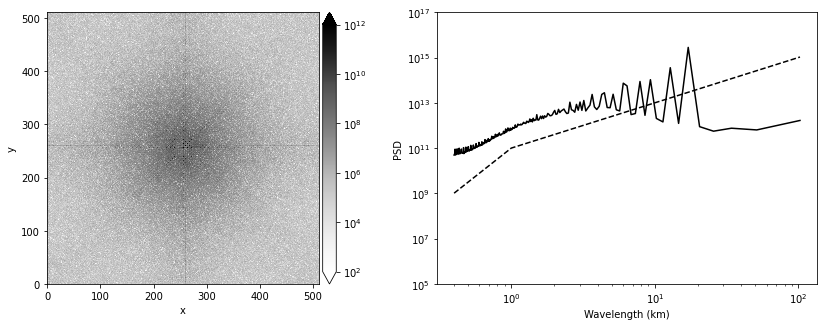

In [30]:
identity_card_ZS('MPT8_M200m')

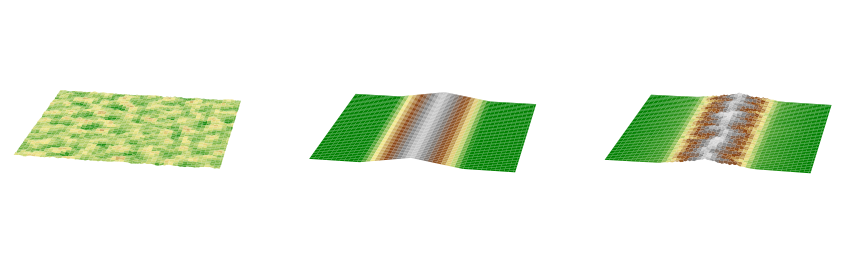

In [16]:
fig = plt.figure(figsize=(15,5))


list_relief = ['MO10_M100m','TRI2_M100m','MOPL_M100m']
for i,relief in enumerate(list_relief):
    ax = fig.add_subplot(int('13'+str(i+1)), projection="3d")
    
    Hc = np.load('../ZSDATA_npy/'+relief+'.npy')
    dx = int(relief[6:9])
    dk = 4 if relief[:3] in ['CON','TRI'] else 1
    
    ny,nx = np.shape(Hc)
    xmax = dx*nx
    x = np.linspace(dx/2,xmax-dx/2,nx)
    xx,yy = np.meshgrid(x,x)
    
    ax.view_init(elev=20., azim=-80)
    ax.dist = 8
    ax.set_axis_off()
    ax.plot_surface(xx,yy,Hc,cmap=hcm,vmax=Hmax,edgecolor=None,linewidth=0)
    ax.set_aspect('equal')

In [37]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
    return pl_colorscale

import plotly
import plotly.graph_objects as go
def interactive_3D_visualization_plotty(Hc,dx,Hmax=2500):
    ny,nx = np.shape(Hc)
    xmax = dx*nx
    x = np.linspace(dx/2,xmax-dx/2,nx)
    xx,yy = np.meshgrid(x,x)
    
    plotly.offline.init_notebook_mode(connected=True)
    terrain = matplotlib_to_plotly(hcm, 255)
    fig = go.Figure(data=[go.Surface(colorscale=terrain,z=Hc,x=xx,y=yy,cmin=0,cmax=Hmax,
                                     lightposition={"x":0, "y":1, "z":1.},
                                    #contours = {"z": {"show": True, "start": 500, "end": 0, "size": 0.05} },
                                    )])

    ratio = xmax/np.max(Hc)
    fig.update_layout(title=relief,scene = {"aspectratio": {"x": ratio, "y": ratio, "z": 1},
                                           #'camera_eye': {"x": 10., "y": 0, "z": 1.5},
                                           #'camera_center': dict(x=0, y=-1, z=1) 
                                           } #dict(x=xmax/3, y=-xmax/6, z=2*Hmax)
                     )
    #fig.show()
    
    # Note that include_plotlyjs is used as cdn so that the static site generator can read it and present it on the browser. This is not typically required.
    html = plotly.offline.plot(fig, filename='3d-terrain-plotly.html',include_plotlyjs='cdn')
    #from IPython.core.display import HTML
    #HTML(html)

In [33]:
relief = 'MOPL_M100m'
Hc = np.load('../ZSDATA_npy/'+relief+'.npy')
dx = int(relief[6:9])
interactive_3D_visualization_plotty(Hc,dx)

In [11]:
def compare_stats(list_relief,lat=0.,Smax = 40,nzbins=81,ft=25):
    ### Partie cartes
    fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15,11))
    
    for i,relief in enumerate(list_relief):
        ax = axs[(i+1)%2,1+(i+1)//2]
        Hc = np.load('../ZSDATA_npy/'+relief+'.npy')
        dx = int(relief[6:9])
        ny,nx = np.shape(Hc)
        extent = (0,nx*dx/1000,0,ny*dx/1000)
        im = ax.imshow(Hc, cmap=hcm,vmin=0,vmax=Hmax, origin='lower',extent=extent,interpolation='none',visible=True)
        
        #ax[0].contour(x/1000,x/1000,Hc, levels=[np.percentile(Hc,5),np.mean(Hc),np.percentile(Hc,95)],linewidths=1.,colors=['k','k','k'],alpha=0.5 ,linestyles=['dashed', 'solid', 'dotted'], zorder=2)
        #plt.colorbar(im,ax=ax[0,3],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
        ax.set_xlabel("x (km)")
        ax.set_ylabel("y (km)")
        #ax.set_xticks([])
        ax.set_title(relief[:4],fontsize=ft)
    
    #x = np.linspace(dx/2,nx*dx-dx/2,nx)
    #xx,yy = np.meshgrid(x,x)
    ZS_flat0_500 = np.zeros((ny,nx))
    #ZS_flat0_500[ (nx*dx-yy)>xx] = 500
    axs[0,0].imshow(ZS_flat0_500, cmap=hcm,vmin=0,vmax=Hmax, origin='lower',extent=extent,interpolation='bilinear',visible=True)
    axs[0,0].set_title("FLAT",fontsize=ft)
    axs[0,0].set_xlabel("x (km)")
    axs[0,0].set_ylabel("y (km)")
    
    axs[0,1].imshow(500*np.ones((ny,nx)), cmap=hcm,vmin=0,vmax=Hmax, origin='lower',extent=extent,interpolation='bilinear',visible=True)
    axs[0,1].set_title("F500",fontsize=ft)
    axs[0,1].set_xlabel("x (km)")
    axs[0,1].set_ylabel("y (km)")
    
        
    cax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    cb = plt.colorbar(im,cax=cax,shrink=1,orientation = "vertical",extend='max',format='%d')
    cb.ax.tick_params(labelsize=ft)
    cb.ax.set_title("    Altitude (m)",fontsize=ft)
    plt.show()
    
    ### Partie comparaison des propriétées des reliefs
    colors = ['tab:orange','tab:blue','tab:green']#,'tab:purple']#]#,'tab:red',
    
    fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(16,6))
    
    z_bins = np.linspace(0.,1.0001,nzbins)*Hmax
    xmax = 30000.
    ax_cum = ax[0].twiny()
    ax_cum.set_xlim([0,1])
    ax_cum.set_xlabel("CDF")
    
    for i,relief in enumerate(list_relief):
        Hc = np.load('../ZSDATA_npy/'+relief+'.npy')
        dx = int(relief[6:9])
        dk = 4 if relief[:3] in ['CON','TRI'] else 1
        ny,nx = np.shape(Hc)
        Hc_max = np.max(Hc)
        Hc_min = np.min(Hc)
        Hc_mean = np.mean(Hc)
        Hc_std = np.std(Hc)
        above_mean_ratio = np.mean(Hc>Hc_mean)
    
        ### Partie distribution d'altitude
        values,_,_ = ax[0].hist(Hc.flatten(),bins=z_bins[:],density=False, orientation="horizontal",alpha=0.3,color=colors[i])
        #xmax = max( xmax , (np.max(values[1:])+np.min(values[1:]))*1.1 )
        
        ax_cum.hist(Hc.flatten(),bins=z_bins[:], density=True, histtype="step", orientation="horizontal",
                cumulative=True,label=relief[:4],color=colors[i])
        #double_arrow = patches.FancyArrowPatch((xmax/2,Hc_mean-Hc_std),(xmax/2,Hc_mean+Hc_std),color='g', arrowstyle='<->', mutation_scale=20)#, arrowstyle='<|-|>'
        #ax[0].add_patch(double_arrow)
        # ax[0].text(xmax/2,Hc_mean+Hc_std+Hmax/40,"Std "+str(round(Hc_std))+'m',color='g',ha='center', va='center')
        # ax_cum.text(1/2,Hmax*3/4,str(round(above_mean_ratio*100))+' % > mean',color='r',ha='center', va='center')
        
        ### Partie Slopes
        Hcs = np.zeros((ny+1,nx+1))
        Hcs[:-1,:-1] = np.copy(Hc)
        Hcs[-1,:] = Hcs[0,:]
        Hcs[:,-1] = Hcs[:,0]
        slopes = np.sqrt( ((Hcs[:-1,:-1]+Hcs[1:,:-1]-Hcs[:-1,1:]-Hcs[1:,1:])/2/dx/np.cos(np.pi*(lat)/180))**2 + ((Hcs[:-1,:-1]+Hcs[:-1,1:]-Hcs[1:,:-1]-Hcs[1:,1:])/2/dx)**2 )
        Hc_slopes = (Hcs[:-1,:-1]+Hcs[1:,:-1]+Hcs[:-1,1:]+Hcs[1:,1:])/4

        slope_bins = np.linspace(0.,np.max(slopes),1000)
        hist_field,_,_,imhs = ax[1].hist2d(slopes.flatten(),Hc_slopes.flatten(),bins=(slope_bins,z_bins),visible=False)
        hist_mean_slopes = np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0)
        ax[1].plot( 180/np.pi*np.arctan(hist_mean_slopes) ,(z_bins[1:]+z_bins[:-1])/2 ,lw=2,label=relief[:4],color=colors[i])
        
        
        ### Partie spectres
        lamda,power = spectrum2D(Hc,dx,dk)
        ax[2].loglog(lamda/1000, power ,label=relief[:4],color=colors[i])
        
        
    ax[0].set_xlim([0,xmax])
    ax[0].set_ylim([0,Hmax])
#     ax[1].set_yticks([])
    ax[0].set_xlabel("Number of pixel")
    ax[0].set_ylabel("Altitude (m)")
    
    ax[0].axhline(np.mean(Hc),color='tab:red',linestyle='--')
    ax[0].text(xmax/4,Hc_mean+Hmax/20,"Mean "+str(round(Hc_mean))+'m',color='tab:red',ha='center', va='center')
    
    #lines, labels = ax[0].get_legend_handles_labels() ; lines2, labels2 = ax_cum.get_legend_handles_labels()
    #ax[0].legend(lines + lines2, labels + labels2, loc=0)
    ax[0].set_title("Surface distributions",fontsize=ft)
    
    ax[1].set_ylim([0,Hmax])
    ax[1].set_xlim([0,Smax])
    ax[1].set_xlabel("Slope (degrees)")
    ax[1].set_ylabel("Altitude (m)")
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3,fontsize=ft)
    ax[1].set_title("Mean slopes",fontsize=ft)
        
    lamda_crit = 1000
    PSD_crit = 1e11
    minlamda = np.min(lamda)
    maxlamda = np.max(lamda)
    scp = 5 # small scale power
    #ax[2].loglog(np.array([minlamda,lamda_crit,maxlamda])/1000,PSD_crit*np.array([(minlamda/lamda_crit)**scp,1.,(maxlamda/lamda_crit)**2]),color='k',linestyle='--',label='theory')
    
    ax[2].set_xlabel("Wavelength (km)")
    ax[2].set_ylabel("PSD")
    ax[2].set_ylim([PSD_crit/1e4,PSD_crit*1e4])
    ax[2].set_title("2D Spectrums",fontsize=ft)
    
    plt.show()

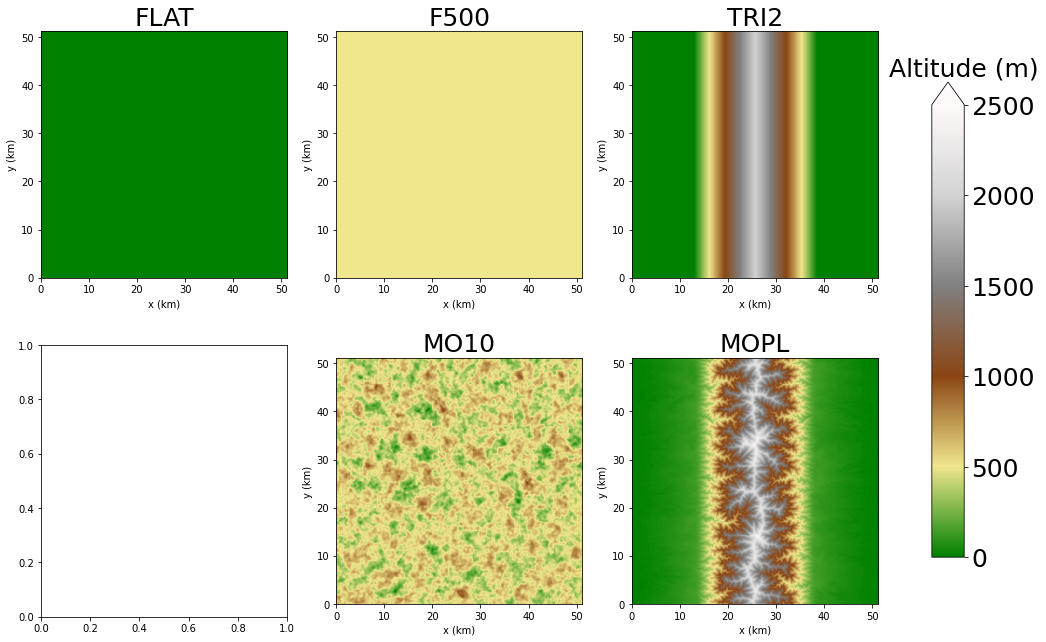

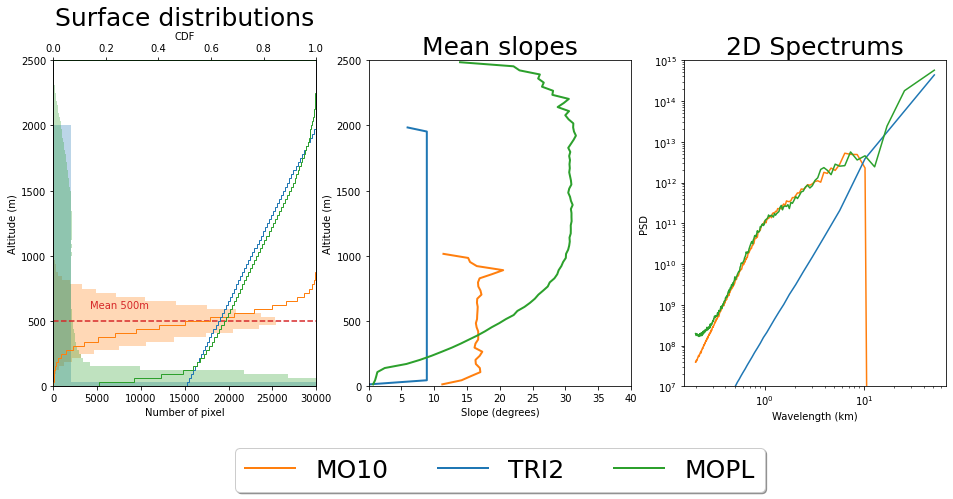

In [12]:
list_relief = ['MO10_M100m','TRI2_M100m','MOPL_M100m']
compare_stats(list_relief)

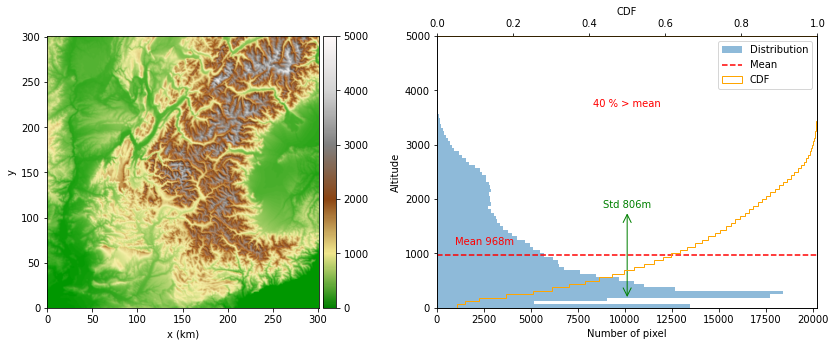

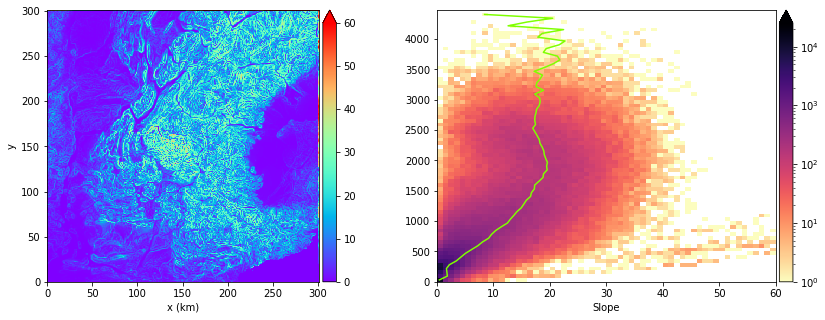

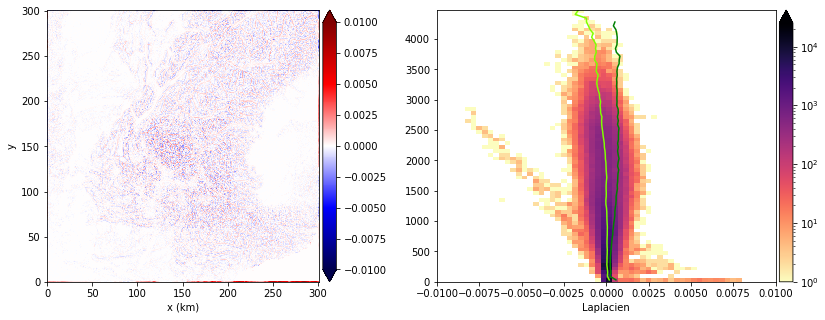

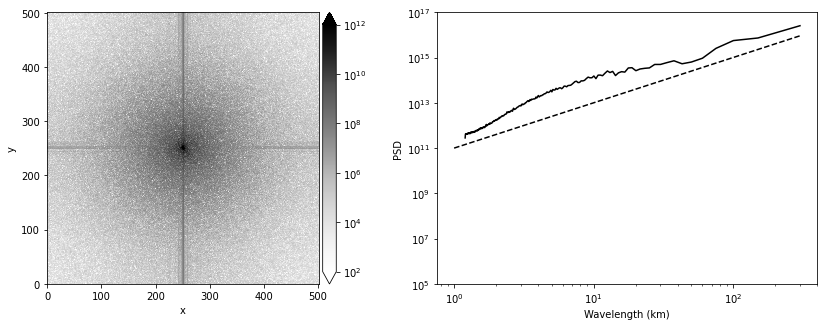

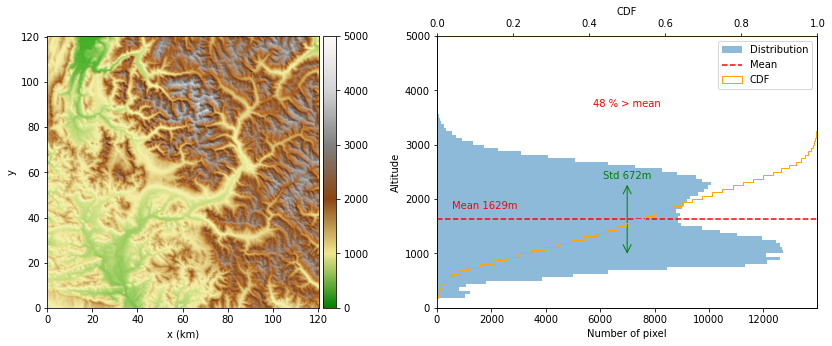

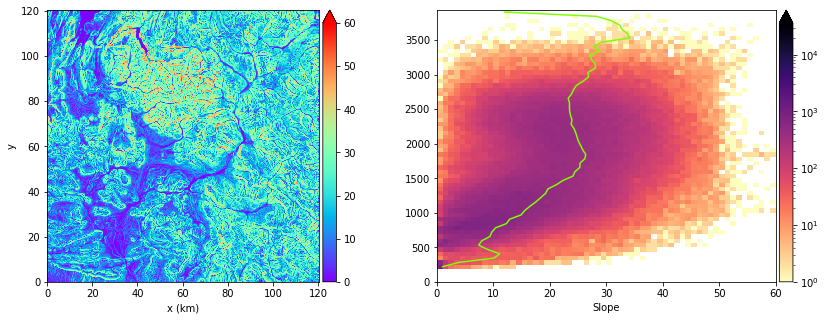

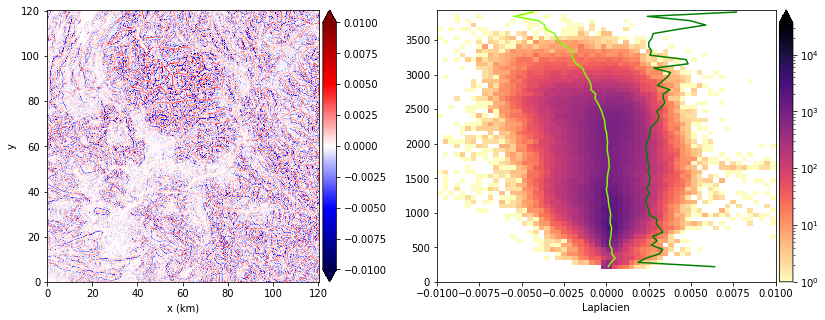

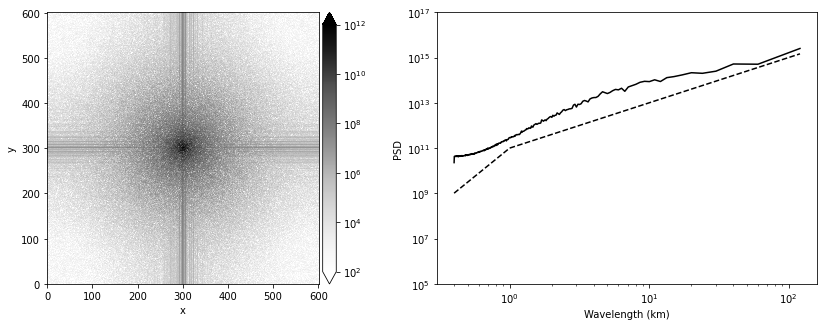

In [41]:
import xarray as xr
userPath = '/home/philippotn'
dataPath = userPath+'/Documents/NO_SAVE/'
simu = 'E620M'
Hmax=5000
for dx in [600,200]:
    Hc = xr.open_dataset(dataPath+'PGD_'+simu+'_'+str(dx)+'m.nc')['ZS'].data
    interactive_3D_visualization_plotty(Hc,dx,Hmax=5000)
    show_all(Hc,dx)